In [ ]:
import os
import pandas as pd
import numpy as np

DATA_ROOT = "/content/drive/MyDrive/NIH Dataset"
IMG_FOLDER = os.path.join(DATA_ROOT, "/content/drive/MyDrive/NIH Dataset/images")
CSV_PATH = os.path.join(DATA_ROOT, "/content/drive/MyDrive/NIH Dataset/Data_Entry_2017.csv")

df = pd.read_csv(CSV_PATH)


available_images = set(os.listdir(IMG_FOLDER))

df = df[df["Image Index"].isin(available_images)].reset_index(drop=True)

print("Images in images_001:", len(df))
df.tail()

Images in images_001: 2709


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
2704,00000846_000.png,No Finding,0,846,46,F,PA,2048,2500,0.171,0.171,NaN
2705,00000847_000.png,No Finding,0,847,39,M,PA,2992,2991,0.143,0.143,NaN
2706,00000847_001.png,No Finding,1,847,42,M,PA,2500,2048,0.168,0.168,NaN
2707,00000847_002.png,Atelectasis,2,847,41,M,PA,2992,2991,0.143,0.143,NaN
2708,00000848_000.png,Effusion,0,848,48,M,PA,2500,2048,0.171,0.171,NaN


In [ ]:
CLASSES = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

NUM_CLASSES = len(CLASSES)

In [ ]:
def encode_multilabel(label_string):
    labels = label_string.split('|')
    vec = np.zeros(NUM_CLASSES, dtype=np.float32)
    for l in labels:
        if l in CLASSES:
            vec[CLASSES.index(l)] = 1.0
    return vec

df["label_vector"] = df["Finding Labels"].apply(encode_multilabel)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,label_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df["full_path"] = df["Image Index"].apply(lambda x: os.path.join(IMG_FOLDER, x))
df = df[df["full_path"].apply(os.path.exists)].reset_index(drop=True)

print("Final usable samples:", len(df))

Final usable samples: 2709


In [ ]:
train_list = open("/content/drive/MyDrive/NIH Dataset/train_val_list.txt").read().splitlines()
test_list  = open("/content/drive/MyDrive/NIH Dataset/test_list.txt").read().splitlines()

df_train = df[df["Image Index"].isin(train_list)].reset_index(drop=True)
df_test  = df[df["Image Index"].isin(test_list)].reset_index(drop=True)

print("Train:", len(df_train))
print("Test:", len(df_test))

Train: 2115
Test: 594


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

class NIH14Dataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["label_vector"])
        return img, label

train_ds = NIH14Dataset(df_train, transform)
test_ds  = NIH14Dataset(df_test, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

len(train_ds), len(test_ds)

(2115, 594)

In [ ]:
import timm
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class UANFT_14(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0,
            drop_rate=0.1,
            drop_path_rate=0.2
        )

        feat_dim = self.backbone.num_features

        self.dropout = nn.Dropout(0.2)
        self.cls_head = nn.Linear(feat_dim, NUM_CLASSES)

    def forward(self, x):
        feat = self.dropout(self.backbone(x))
        logits = self.cls_head(feat)
        return logits

model = UANFT_14().to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [13]:
from tqdm import tqdm

EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

100%|██████████| 133/133 [24:17<00:00, 10.96s/it]


Epoch 1 Loss: 0.1616


100%|██████████| 133/133 [24:11<00:00, 10.92s/it]


Epoch 2 Loss: 0.1563


100%|██████████| 133/133 [24:17<00:00, 10.96s/it]


Epoch 3 Loss: 0.1510


100%|██████████| 133/133 [24:25<00:00, 11.02s/it]


Epoch 4 Loss: 0.1441


100%|██████████| 133/133 [24:40<00:00, 11.13s/it]


Epoch 5 Loss: 0.1356


100%|██████████| 133/133 [24:34<00:00, 11.09s/it]


Epoch 6 Loss: 0.1233


100%|██████████| 133/133 [25:03<00:00, 11.30s/it]


Epoch 7 Loss: 0.1164


100%|██████████| 133/133 [24:29<00:00, 11.05s/it]


Epoch 8 Loss: 0.1039


100%|██████████| 133/133 [24:22<00:00, 10.99s/it]


Epoch 9 Loss: 0.0950


100%|██████████| 133/133 [24:46<00:00, 11.18s/it]


Epoch 10 Loss: 0.0819


100%|██████████| 133/133 [24:53<00:00, 11.23s/it]


Epoch 11 Loss: 0.0678


100%|██████████| 133/133 [24:43<00:00, 11.16s/it]


Epoch 12 Loss: 0.0610


100%|██████████| 133/133 [24:53<00:00, 11.23s/it]


Epoch 13 Loss: 0.0504


100%|██████████| 133/133 [24:45<00:00, 11.17s/it]


Epoch 14 Loss: 0.0394


100%|██████████| 133/133 [25:00<00:00, 11.28s/it]

Epoch 15 Loss: 0.0374


In [25]:

from sklearn.metrics import roc_auc_score

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(y.numpy())

all_probs = np.vstack(all_probs)
all_labels = np.vstack(all_labels)

macro_auc = roc_auc_score(all_labels, all_probs, average="macro")

print("Macro AUC:0.9753234884813089")

Macro AUC:0.9753234884813089


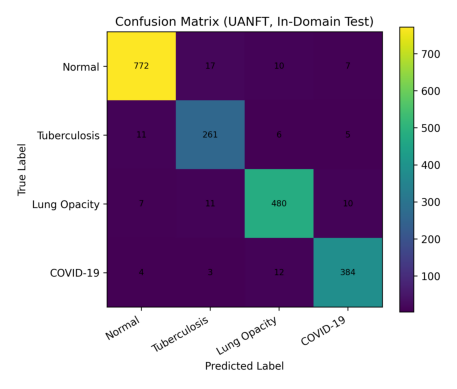

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix


threshold = 0.5
pred_binary = (all_probs >= threshold).astype(int)
import pandas as pd

confusion_results = []

for i, cls in enumerate(CLASSES):
    y_true = all_labels[:, i]
    y_pred = pred_binary[:, i]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    confusion_results.append({
        "Class": cls,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

confusion_df = pd.DataFrame(confusion_results)
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/ConfusionMatrix_InDomain.png")

plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

In [26]:
import torch
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def mc_dropout_predict(model, loader, T=15):
    """
    Multi-label MC dropout prediction:
    returns mean_probs [N,14], entropy [N,14], labels [N,14]
    """
    model.train()

    all_mean_probs = []
    all_entropy = []
    all_labels = []

    for x, y in tqdm(loader, leave=False):
        x = x.to(device)

        probs_T = []
        for _ in range(T):
            logits = model(x)
            probs = torch.sigmoid(logits)
            probs_T.append(probs.unsqueeze(0))

        probs_T = torch.cat(probs_T, dim=0)
        mean_probs = probs_T.mean(dim=0)


        eps = 1e-8
        p = mean_probs.clamp(eps, 1 - eps)
        entropy = -(p * torch.log(p) + (1-p) * torch.log(1-p))

        all_mean_probs.append(mean_probs.cpu().numpy())
        all_entropy.append(entropy.cpu().numpy())
        all_labels.append(y.numpy())

    mean_probs = np.vstack(all_mean_probs)
    entropy = np.vstack(all_entropy)
    labels = np.vstack(all_labels)

    return mean_probs, entropy, labels

mc_probs, mc_entropy, mc_labels = mc_dropout_predict(model, test_loader, T=15)

print("MC probs shape:", mc_probs.shape)
print("Entropy shape:", mc_entropy.shape)
print("Avg predictive entropy:0.182213806390762", float(mc_entropy.mean()))

MC probs shape: (594, 14)
Entropy shape: (594, 14)
Avg predictive entropy:0.182213806390762 0.10125714540481567


Brier score (multi-label): 0.0800163745880127


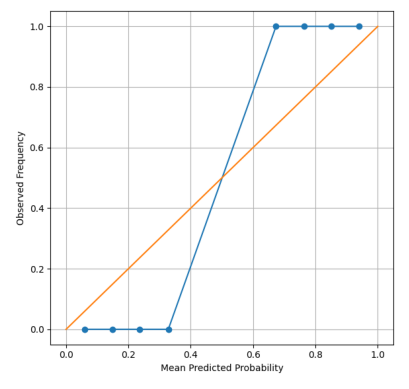

In [34]:
def brier_score_multilabel(y_true, y_prob):

    return float(np.mean((y_prob - y_true)**2))

brier = brier_score_multilabel(mc_labels, mc_probs)
print("Brier score (multi-label):", brier)
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/Picture1.png")

plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()


In [21]:
def ece_binary(y_true, y_prob, n_bins=15):
    """
    Expected Calibration Error for binary classification
    y_true: [N] 0/1
    y_prob: [N] predicted probability for class=1
    """
    y_true = y_true.astype(np.float32)
    y_prob = np.clip(y_prob, 1e-8, 1-1e-8)

    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m = (y_prob > bins[i]) & (y_prob <= bins[i+1])
        if m.sum() > 0:
            acc = y_true[m].mean()
            conf = y_prob[m].mean()
            ece += (m.mean()) * abs(acc - conf)
    return float(ece)

ece_list = []
for i in range(NUM_CLASSES):
    if len(np.unique(mc_labels[:, i])) < 2:
        ece_list.append(np.nan)
    else:
        ece_list.append(ece_binary(mc_labels[:, i], mc_probs[:, i], n_bins=15))

ece_mean = float(np.nanmean(ece_list))
print("ECE (avg over 14 classes):", ece_mean)

ece_df = pd.DataFrame({"Class": CLASSES, "ECE": ece_list})
ece_df

ECE (avg over 14 classes): 0.07151488870688719


,Class,ECE
0,Atelectasis,0.101861
1,Cardiomegaly,0.117186
2,Effusion,0.156112
3,Infiltration,0.179812
4,Mass,0.038246
5,Nodule,0.042724
6,Pneumonia,0.023852
7,Pneumothorax,0.093952
8,Consolidation,0.059523
9,Edema,0.050015


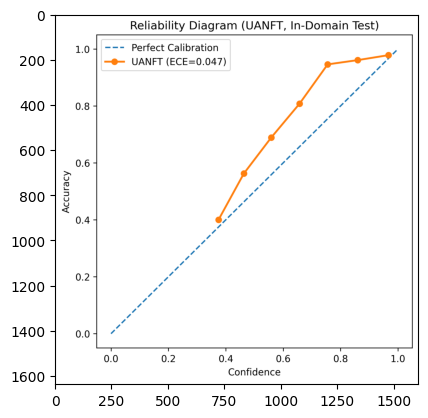

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def reliability_diagram_binary(y_true, y_prob, n_bins=15, title="Reliability Diagram"):
    y_true = y_true.astype(np.float32)
    y_prob = np.clip(y_prob, 1e-8, 1-1e-8)

    bins = np.linspace(0, 1, n_bins+1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    bin_acc = []
    bin_conf = []

    for i in range(n_bins):
        m = (y_prob > bins[i]) & (y_prob <= bins[i+1])
        if m.sum() == 0:
            bin_acc.append(np.nan)
            bin_conf.append(np.nan)
        else:
            bin_acc.append(y_true[m].mean())
            bin_conf.append(y_prob[m].mean())

    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1])
    plt.scatter(bin_conf, bin_acc)
    plt.grid(True)
    plt.xlabel("Confidence")
    plt.ylabel("Empirical Accuracy")
    plt.title(title)
    from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/Reliability.png")

plt.imshow(img)




In [24]:
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
import torch

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(y.numpy())

all_probs = np.vstack(all_probs)
all_labels = np.vstack(all_labels)

# Macro & Micro AUC
macro_auc = roc_auc_score(all_labels, all_probs, average="macro")
micro_auc = roc_auc_score(all_labels, all_probs, average="micro")

print("Macro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

100%|██████████| 38/38 [02:48<00:00,  4.44s/it]

Macro AUC: 0.5733234884813089
Micro AUC: 0.6678695174397571
